In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [87]:
data = pd.read_csv('/content/drive/My Drive/data/viettri_quality.csv', index_col='date')

In [88]:
data

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,44,17,29,2,9,4
3/2/2019,65,37,27,4,12,4
3/3/2019,81,38,2,1,1,2
3/4/2019,51,24,21,4,8,1
3/5/2019,43,7,23,1,12,4
...,...,...,...,...,...,...
5/28/2024,38,24,35,1,15,5
5/29/2024,38,17,41,7,15,10
5/30/2024,28,8,11,1,15,1


In [89]:
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
data['pm25'] = scaler.fit_transform(data[['pm25']])

In [90]:
def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data['pm25'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [92]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 10)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               1408      
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=12)

Epoch 1/50
128/128 [==============================] - 2s 8ms/step - loss: 0.0255 - val_loss: 0.0111
Epoch 2/50
128/128 [==============================] - 1s 6ms/step - loss: 0.0229 - val_loss: 0.0101
Epoch 3/50
128/128 [==============================] - 1s 6ms/step - loss: 0.0225 - val_loss: 0.0100
Epoch 4/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0221 - val_loss: 0.0104
Epoch 5/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0216 - val_loss: 0.0111
Epoch 6/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0209 - val_loss: 0.0103
Epoch 7/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0210 - val_loss: 0.0110
Epoch 8/50
128/128 [==============================] - 0s 4ms/step - loss: 0.0203 - val_loss: 0.0098
Epoch 9/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0094
Epoch 10/50
128/128 [==============================] - 0s 4ms/step - loss: 0.0195 - val_loss: 0.0096

In [94]:
print('Actual value: %s'%str(y[-5:]))
print('Predict value:')
yhat = model.predict(X_test)
print(yhat)

Actual value: [0.20903955 0.20903955 0.15254237 0.06214689 0.11299435]
Predict value:
12/12 [==============================] - 0s 2ms/step
[[0.289217  ]
 [0.21039423]
 [0.2159799 ]
 [0.22576809]
 [0.2995722 ]
 [0.2995914 ]
 [0.30086413]
 [0.31975672]
 [0.25242034]
 [0.19223127]
 [0.16148014]
 [0.16976306]
 [0.22525278]
 [0.21435642]
 [0.26286054]
 [0.23762667]
 [0.24765226]
 [0.24754885]
 [0.09692176]
 [0.22350824]
 [0.15710321]
 [0.19111758]
 [0.13516735]
 [0.27320948]
 [0.25840312]
 [0.18817174]
 [0.1920667 ]
 [0.23997259]
 [0.17091978]
 [0.14521712]
 [0.23273343]
 [0.19446304]
 [0.25688726]
 [0.1350875 ]
 [0.14535853]
 [0.16054115]
 [0.15638822]
 [0.159929  ]
 [0.10777692]
 [0.14339377]
 [0.1071922 ]
 [0.18357062]
 [0.22826433]
 [0.1214949 ]
 [0.12730986]
 [0.1258463 ]
 [0.16514981]
 [0.12168719]
 [0.12029579]
 [0.13554636]
 [0.13743743]
 [0.13447091]
 [0.13999245]
 [0.14328104]
 [0.1170656 ]
 [0.12212355]
 [0.10896017]
 [0.11793964]
 [0.11154939]
 [0.12505874]
 [0.09013225]
 [0.143

In [95]:
def RMSE(yhat, y):
    return np.sqrt(np.mean((yhat - y)**2))

yhat = model.predict(X)
RMSE(yhat, y)

60/60 [==============================] - 0s 2ms/step


0.23530643136708287

In [96]:
yhat_inverse = scaler.inverse_transform(np.array(yhat).reshape(-1, 1))

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y, yhat))
mape = mean_absolute_percentage_error(y, yhat)
mae = mean_absolute_error(y, yhat)

print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

RMSE: 0.09535978165043127
MAPE: 22643666557475.63
MAE: 0.07268038402219025


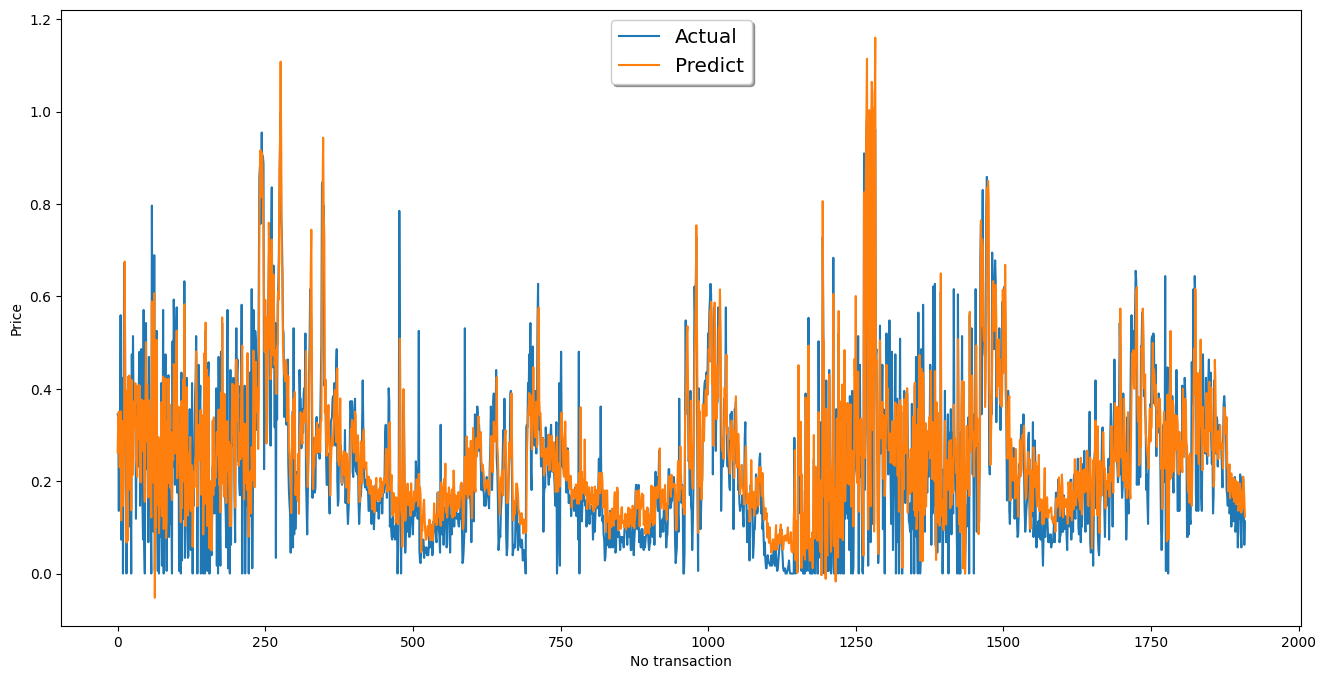

In [98]:
def plt_graph(y, yhat):
    plt.figure(figsize = (16, 8))
    plt.plot(y, label = 'Actual')
    plt.plot(yhat, label = 'Predict')
    plt.xlabel('No transaction')
    plt.ylabel('Price')
    legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')


plt_graph(y, yhat)


In [99]:
# Predict the next 90 days PM2.5 values
last_sequence = X_test[-1]
predictions = []
current_sequence = last_sequence

for _ in range(90):
    next_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(next_value)
    current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Next 90 days PM2.5 predictions:", predictions.flatten())

1/1 [==============================] - 0s 36ms/step
Next 90 days PM2.5 predictions: [22.82526  27.88085  40.16251  40.028618 36.164627 35.4999   32.403774
 38.02191  43.184338 43.21786  42.71153  40.03346  40.08828  42.85607
 44.51486  45.616165 44.3013   43.410343 44.521927 45.76741  47.034256
 47.088917 46.50279  46.79982  47.51827  48.482285 49.05918  49.01179
 49.116524 49.501236 50.173016 50.831867 51.122623 51.201023 51.32522
 51.657032 52.16098  52.552948 52.735176 52.80775  52.938187 53.224403
 53.566772 53.817177 53.938538 54.009304 54.148296 54.378063 54.618637
 54.78821  54.877426 54.953785 55.082615 55.25947  55.424473 55.528423
 55.583706 55.643597 55.740803 55.85644  55.951836 56.00216  56.021984
 56.04666  56.094883 56.154293 56.19843  56.21466  56.215946 56.224392
 56.249657 56.28148  56.3025   56.30659  56.303326 56.30671  56.321274
 56.338974 56.348938 56.34847  56.34462  56.34614  56.35481  56.36474
 56.369194 56.3673   56.36412  56.36499  56.37033  56.375946]


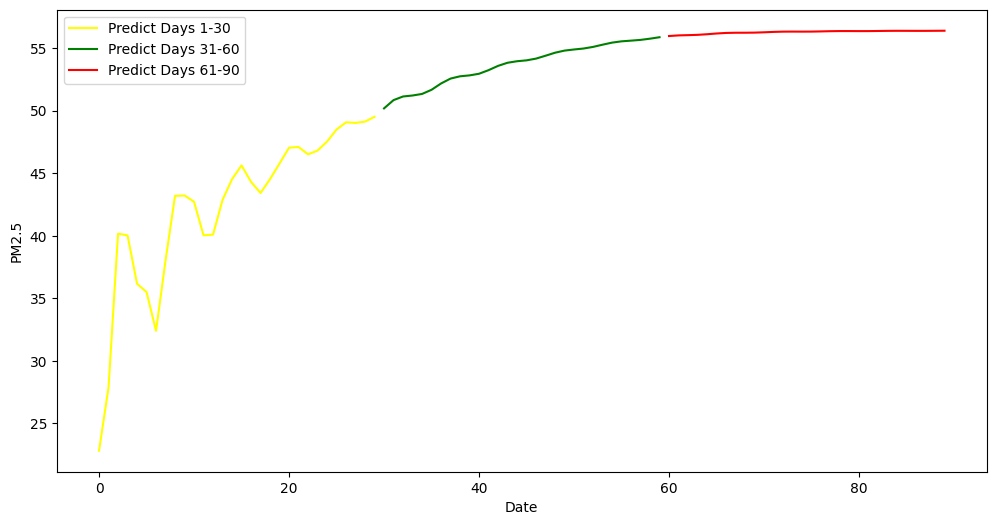

In [100]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
df = pd.DataFrame({'Date': dates, 'predictions': predictions.flatten()}) # Flatten predictions to 1D array

plt.plot(df['predictions'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(df['predictions'][30:60], color='green', label='Predict Days 31-60')
plt.plot(df['predictions'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()